In [1]:
# JUST FOR TESTING PURPOSES, DATASET CREATION IN run_gnn_model

In [48]:
import sys
#print(sys.path)
# sys.path.insert(0, '/eos/user/c/czeh/.local/lib/python3.9/site-packages')

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

input_folder = "/eos/user/c/czeh/histo"
output_folder = "/eos/user/c/czeh/graph_data"

The scikit-learn version is 1.5.1.
Python version
3.11.9 (main, Jun 24 2024, 14:32:54) [GCC 11.3.0]
Version info.
sys.version_info(major=3, minor=11, micro=9, releaselevel='final', serial=0)


In [49]:
import os
from glob import glob
from tqdm import tqdm
from itertools import chain

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch_geometric.data import Data

import awkward as ak
import numpy as np

print('The numpy version is {}.'.format(np.__version__))

import uproot as uproot
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree
import scipy.spatial.distance

from ClusterDataset import ClusterDataset
from torch_geometric.loader.dataloader import DataLoader

%matplotlib inline

The numpy version is 1.26.4.


In [50]:
# use this to load the tree if some of file.keys() are duplicates ending with different numbers
def load_branch_with_highest_cycle(file, branch_name):

    # Get all keys in the file
    all_keys = file.keys()

    # Filter keys that match the specified branch name
    matching_keys = [key for key in all_keys if key.startswith(branch_name)]

    if not matching_keys:
        raise ValueError(f"No branch with name '{branch_name}' found in the file.")

    # Find the key with the highest cycle
    highest_cycle_key = max(matching_keys, key=lambda key: int(key.split(";")[1]))

    # Load the branch with the highest cycle
    branch = file[highest_cycle_key]

    return branch

In [51]:
# input_folder = "/eos/user/a/aperego/SampleProduction/TICLv5/ParticleGunPion/histo"
files = glob(f"{input_folder}/train/*.root")
print(files[0])
file = uproot.open(files[0])
print(file.keys())

alltracksters = load_branch_with_highest_cycle(file,'ticlDumper/ticlTrackstersCLUE3DHigh')
allclusters = load_branch_with_highest_cycle(file,'ticlDumper/clusters')
allsimtrackstersCP = load_branch_with_highest_cycle(file, 'ticlDumper/simtrackstersCP')
allassociations = load_branch_with_highest_cycle(file, 'ticlDumper/associations')
allgraph = load_branch_with_highest_cycle(file, 'ticlDumper/TICLGraph')
print(alltracksters.show())
allassociations.arrays()

/eos/user/c/czeh/histo/train/histo.root
['ticlDumper;1', 'ticlDumper/ticlTrackstersCLUE3DHigh;1', 'ticlDumper/ticlTracksterLinks;1', 'ticlDumper/ticlCandidate;1', 'ticlDumper/ticlTracksterLinksSuperclusteringDNN;1', 'ticlDumper/simtrackstersSC;1', 'ticlDumper/simtrackstersCP;1', 'ticlDumper/clusters;1', 'ticlDumper/candidates;1', 'ticlDumper/TICLGraph;1', 'ticlDumper/superclustering;1', 'ticlDumper/associations;1', 'ticlDumper/tracks;1', 'ticlDumper/simTICLCandidate;1']
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
event                | edm::EventID             | AsGroup(<TBranchElement 'ev...
event/run_           | uint32_t                 | AsDtype('>u4')
event/luminosityB... | uint32_t                 | AsDtype('>u4')
event/event_         | uint64_t                 | AsDtype('>u8')
NTracksters          | uint32_t                 | AsDtype('>u4')
NClusters            |

<Array [{run_: 1, ...}, ..., {run_: 1, ...}] type='100 * {run_: uint32, lum...'>

In [52]:
node_feature_keys_before = ["barycenter_x", "barycenter_y", "barycenter_z", "barycenter_eta", "barycenter_phi", "eVector0_x", "eVector0_y", "eVector0_z",  "EV1", "EV2", "EV3", "sigmaPCA1", "sigmaPCA2", "sigmaPCA3", "raw_energy", "raw_em_energy", "time"]
data = alltracksters.arrays(node_feature_keys_before)
data

<Array [{barycenter_x: [...], ...}, ..., {...}] type='100 * {barycenter_x: ...'>

In [53]:
allgraph.arrays()[0]

<Record {inner: [[], ...], outer: [...]} type='{inner: var * var * uint32, ...'>

In [35]:
alltracksters_array = alltracksters.arrays()
allassociations_array = allassociations.arrays()
cluster_number_of_hits = allclusters.arrays().cluster_number_of_hits
cluster_layer_id = allclusters.arrays().cluster_layer_id
vertices_indexes = alltracksters.arrays().vertices_indexes
NTracksters = alltracksters.arrays().NTracksters

In [36]:
data["vertices"] = ak.concatenate([alltracksters_array["vertices_x"][:, :, :, np.newaxis], alltracksters_array["vertices_y"][:, :, :, np.newaxis], alltracksters_array["vertices_z"][:, :, :, np.newaxis]], axis=-1)

In [37]:
data["vertices"][0]

<Array [[[62.8, 17.8, 374], ..., [...]], ...] type='6 * var * 3 * float32'>

In [38]:
num_LCs = ak.count(alltracksters.arrays().vertices_indexes, axis=2)
data["num_LCs"] = num_LCs

In [39]:
data["z_min"] = ak.min(alltracksters.arrays().vertices_z, axis=2)
data["z_max"] = ak.max(alltracksters.arrays().vertices_z, axis=2)


In [40]:
volume = 2*(3 - 1.5) * (2 * 47)
data["trackster_density"] = ak.Array(np.zeros_like(data.num_LCs)) + NTracksters / volume
data["LC_density"] = data.num_LCs / volume

In [41]:
hits = ak.to_list(np.zeros_like(data.num_LCs))
length = ak.to_list(np.zeros_like(data.num_LCs))

cluster_hits = cluster_number_of_hits[ak.flatten(vertices_indexes, axis=-1)]
cluster_layer_ids = cluster_layer_id[ak.flatten(vertices_indexes, axis=-1)]
vertices_count = ak.count(vertices_indexes, axis=-1)

for i in tqdm(range(len(alltracksters.arrays()))):
    hits[i] = ak.sum(ak.unflatten(cluster_hits[i], vertices_count[i]), axis=-1)
    length[i] = (ak.max(ak.unflatten(cluster_layer_ids[i], vertices_count[i]), axis=-1) - ak.min(ak.unflatten(cluster_layer_ids[i], vertices_count[i]), axis=-1)) / 47
        
data["num_hits"] = hits
data["length"] = length


100%|██████████| 100/100 [00:00<00:00, 282.13it/s]


In [42]:
data["photon_prob"] = alltracksters.arrays()["id_probabilities"][:, :, 0]
data["electron_prob"] = alltracksters.arrays()["id_probabilities"][:, :, 1]
data["muon_prob"] = alltracksters.arrays()["id_probabilities"][:, :, 2]
data["neutral_pion_prob"] = alltracksters.arrays()["id_probabilities"][:, :, 3]
data["charged_hadron_prob"] = alltracksters.arrays()["id_probabilities"][:, :, 4]
data["neutral_hadron_prob"] = alltracksters.arrays()["id_probabilities"][:, :, 5]

In [43]:
idx = allassociations_array.ticlTrackstersCLUE3DHigh_recoToSim_CP_score<0.2
simTracksters = allassociations_array.ticlTrackstersCLUE3DHigh_recoToSim_CP[allassociations_array.ticlTrackstersCLUE3DHigh_recoToSim_CP_score<0.2]
emptys = np.full_like(ak.count(allassociations_array.ticlTrackstersCLUE3DHigh_recoToSim_CP, axis=-1), -1) 

data["y"] = ak.flatten(ak.where(ak.count(simTracksters, axis=-1)==1, allassociations_array.ticlTrackstersCLUE3DHigh_recoToSim_CP[idx], ak.unflatten(emptys, 1, axis=-1)), axis=-1)
data["shared_e"] = ak.flatten(ak.where(ak.count(simTracksters, axis=-1)==1, allassociations_array.ticlTrackstersCLUE3DHigh_recoToSim_CP_sharedE[idx], ak.unflatten(emptys, 1, axis=-1)), axis=-1)
data["score"] = ak.flatten(ak.where(ak.count(simTracksters, axis=-1)==1, allassociations_array.ticlTrackstersCLUE3DHigh_recoToSim_CP_score[idx], ak.unflatten(emptys, 1, axis=-1)), axis=-1)

In [58]:
allassociations_array.ticlTrackstersCLUE3DHigh_recoToSim_CP

<Array [[[0], [0], [0], ..., [0], [0]], ...] type='100 * var * var * uint32'>

In [18]:
node_feature_keys = ["barycenter_x", "barycenter_y", "barycenter_z", "y", "barycenter_eta", "barycenter_phi", "eVector0_x", "eVector0_y", "eVector0_z",  "EV1", "EV2", "EV3", "sigmaPCA1", "sigmaPCA2", "sigmaPCA3", "num_LCs", "num_hits", "raw_energy", "raw_em_energy", "photon_prob", "electron_prob", "muon_prob", "neutral_pion_prob", "charged_hadron_prob", "neutral_hadron_prob", "z_min", "z_max", "length", "LC_density", "trackster_density", "time"]
thesis_feature_names = ["x", "y", "z", "valid", "eta", "phi", "eig_x", "eig_y", "eig_z",  "EV1", "EV2", "EV3", "sigmaPCA_x", "sigmaPCA_y", "sigmaPCA_z", "num_LC", "num_hits", "raw_energy", "raw_em_energy", "photon_prob", "electron_prob", "muon_prob", "neutral_pion_prob", "charged_hadron_prob", "neutral_hadron_prob", "z_min", "z_max", "length", "LC_density", "trackster_density", "time"]

100%|██████████| 31/31 [00:09<00:00,  3.32it/s]
/tmp/ipykernel_726/3466913950.py:18: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


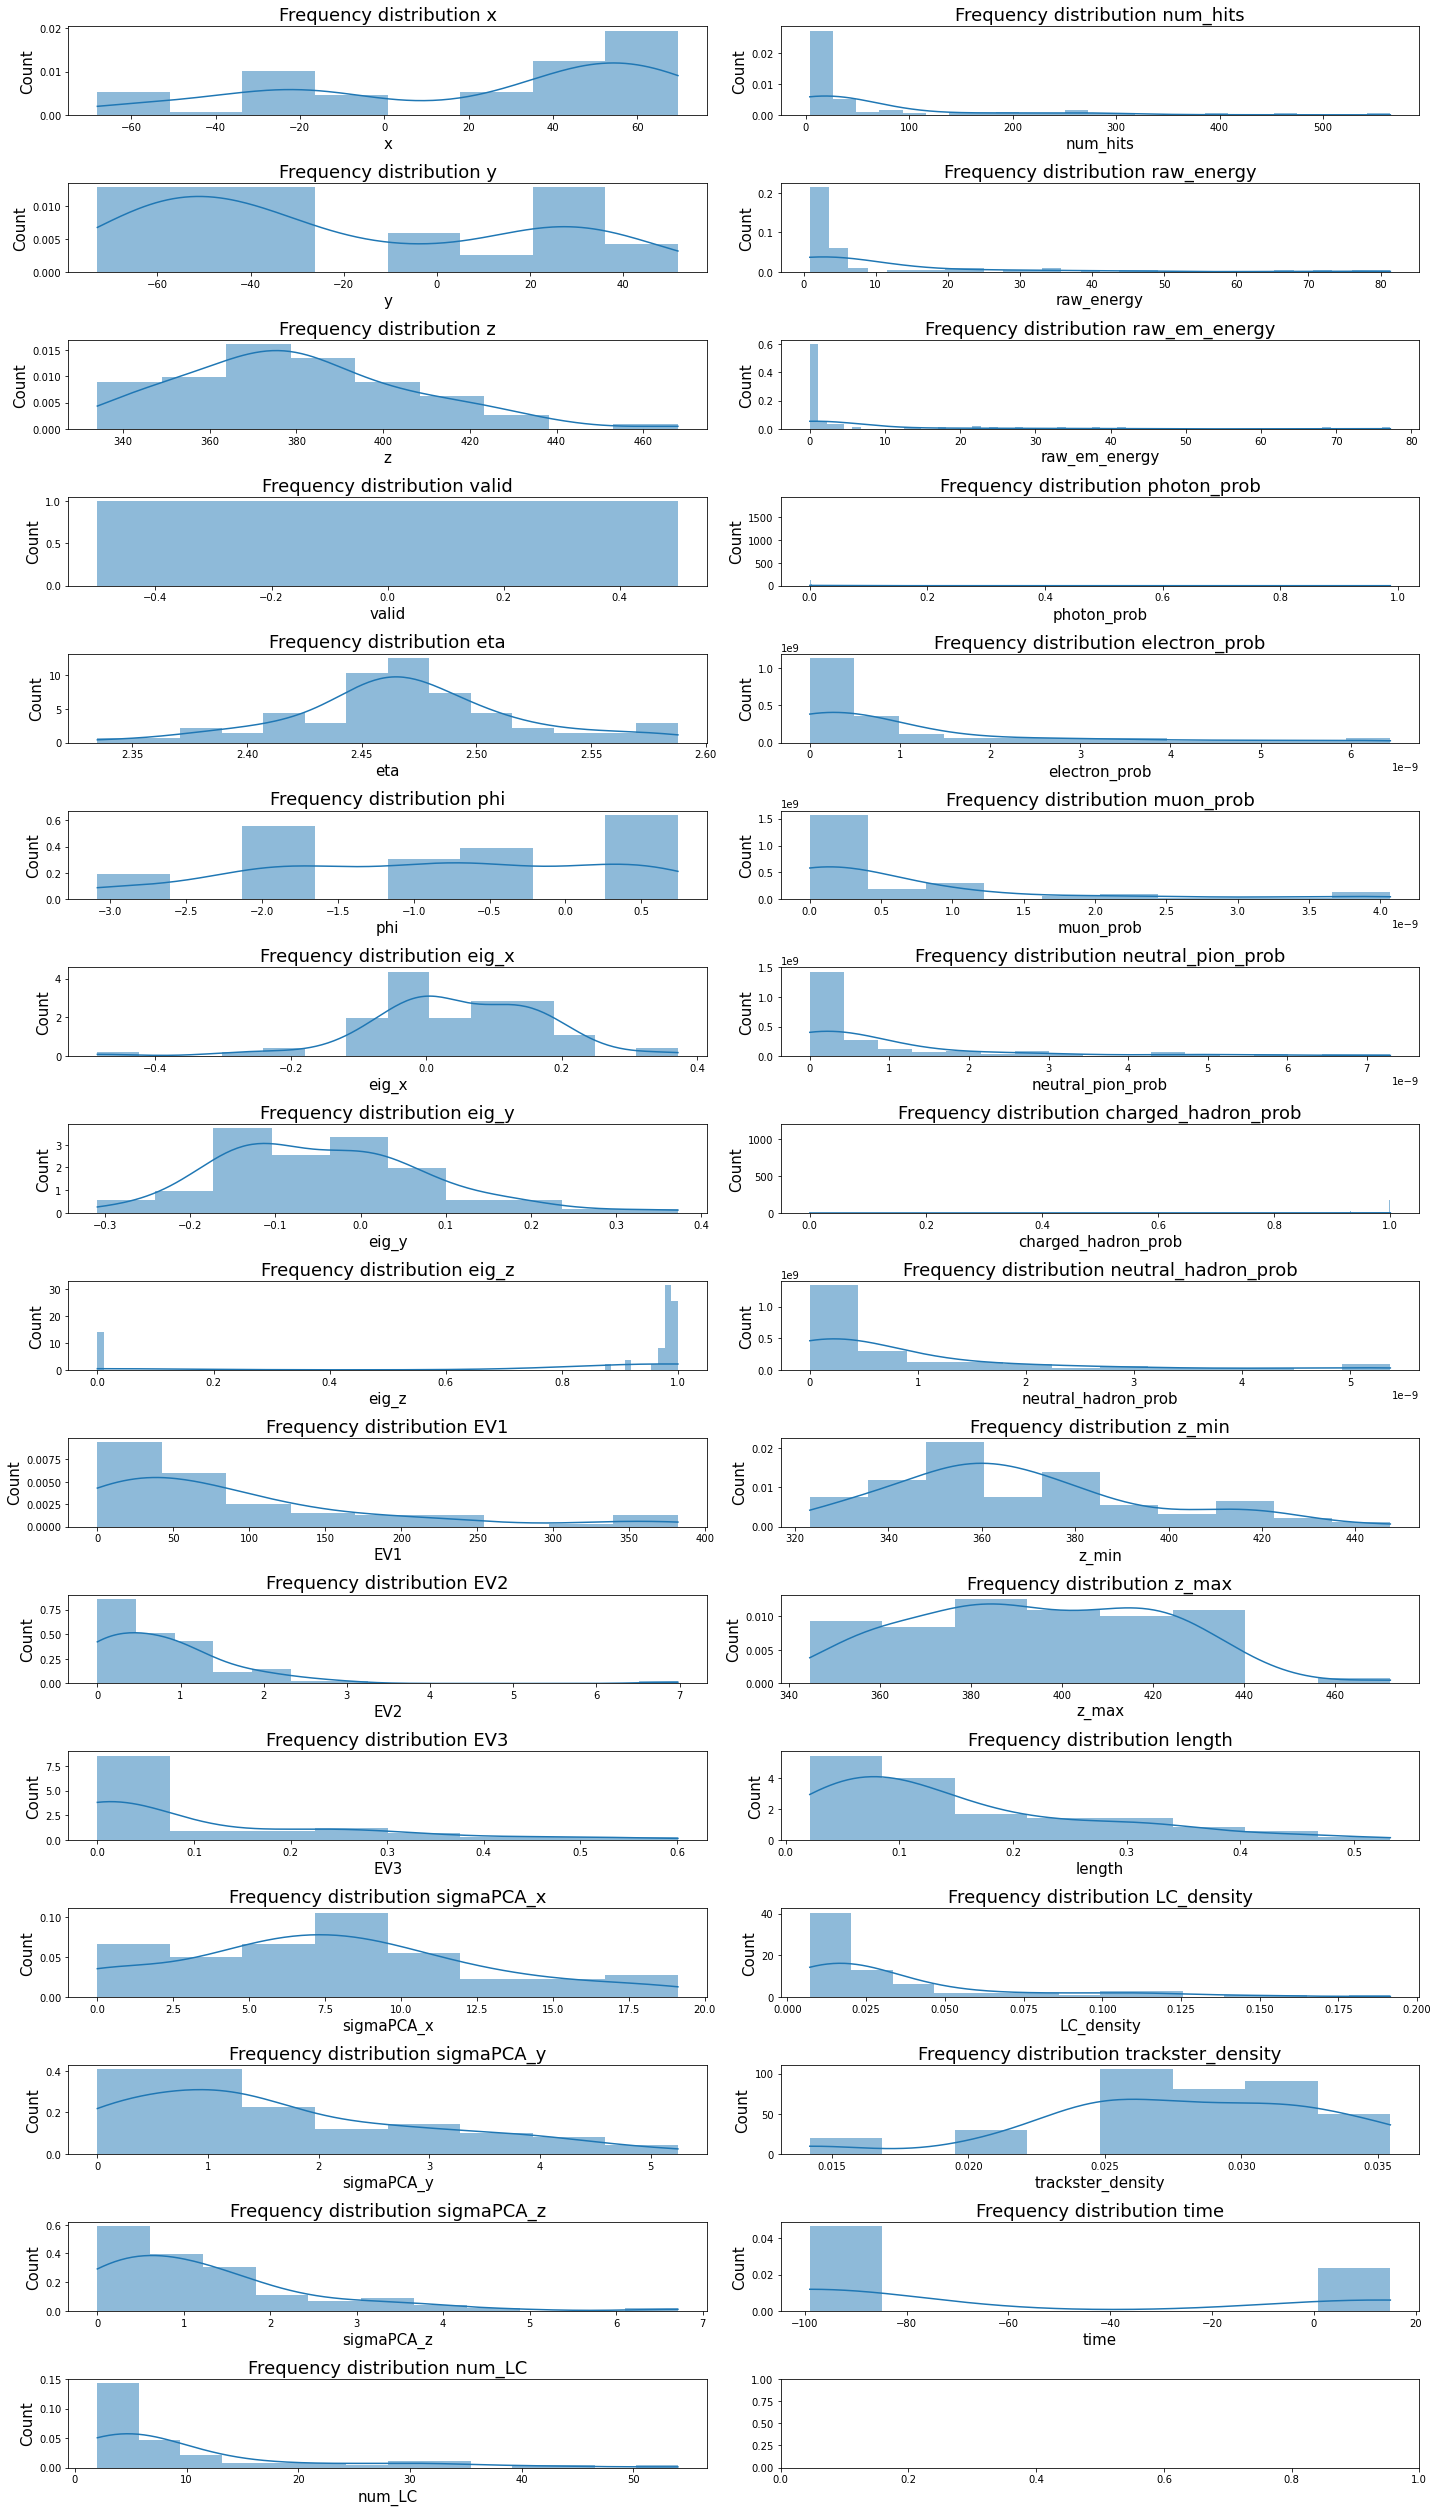

In [19]:
track_vals = []

scols = int(np.ceil(len(node_feature_keys)/2))
srows = 2
fig, axes = plt.subplots(scols, srows, figsize=(20, 35), constrained_layout=True)

for i in tqdm(range(len(node_feature_keys))):
    ax_col = int(i%scols)
    ax_row = int(i/scols)
    
    values = ak.flatten(data[node_feature_keys[i]])
    track_vals.append(values)
    sns.histplot(values, ax=axes[ax_col, ax_row], kde=True, stat="density", linewidth=0)
    axes[ax_col, ax_row].set_title('Frequency distribution '+ thesis_feature_names[i], fontsize=18)
    axes[ax_col, ax_row].set_xlabel(thesis_feature_names[i], fontsize=15)
    axes[ax_col, ax_row].set_ylabel('Count', fontsize=15)
    
fig.tight_layout()
plt.show()

In [20]:
track_vals = np.array(track_vals)

In [21]:
corr_matrix = np.corrcoef(track_vals)
print(corr_matrix.shape)

(31, 31)


/cvmfs/sft.cern.ch/lcg/views/LCG_107_cuda/x86_64-el9-gcc11-opt/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cvmfs/sft.cern.ch/lcg/views/LCG_107_cuda/x86_64-el9-gcc11-opt/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Text(0.5, 1.0, 'Correlation Matrix of the Trackster Features')

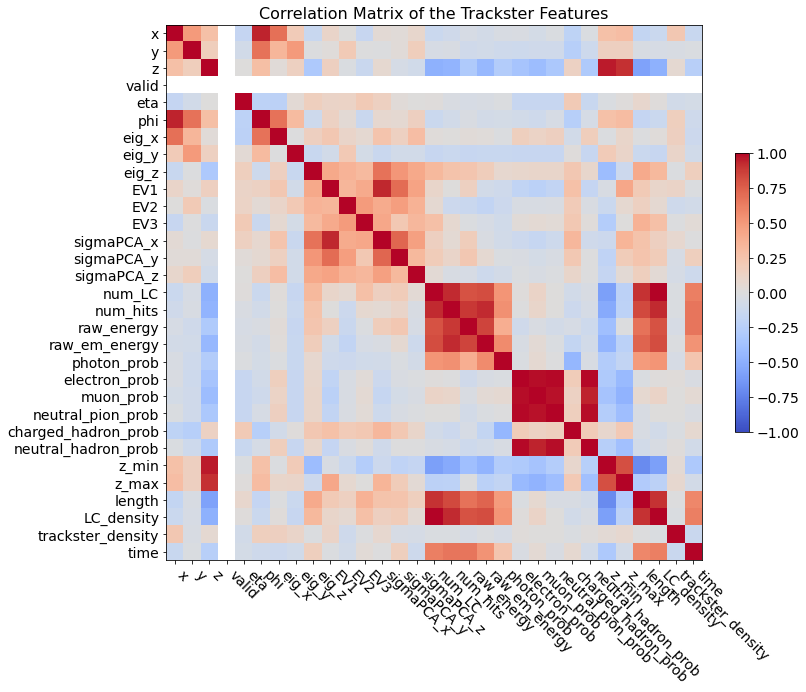

In [22]:
f = plt.figure(figsize=(12, 10))
plt.matshow(corr_matrix, fignum=f.number, cmap='coolwarm', vmin=-1, vmax=1)

plt.xticks(range(len(thesis_feature_names)), thesis_feature_names, fontsize=14, rotation=-45, ha="left")
plt.yticks(range(len(thesis_feature_names)), thesis_feature_names, fontsize=14)
ax = plt.gca()
ax.xaxis.set_ticks_position('bottom')
cb = plt.colorbar(shrink=0.5)
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix of the Trackster Features', fontsize=16)

Text(0.5, 0, 'z (cm)')

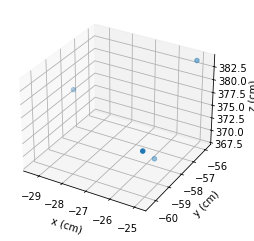

In [23]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(data[0].barycenter_x, data[0].barycenter_y, data[0].barycenter_z)

ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
ax.set_zlabel('z (cm)')

In [24]:
graph_list = []
for event in range(len(data)):    
    nodes = np.zeros((NTracksters[event], len(node_feature_keys)))
    for i, key in enumerate(node_feature_keys):
        nodes[:, i] = ak.to_numpy(data[event][key])

    edges = [[], []]
    for i in range(NTracksters[event]):
        edges[0].extend([i] * (NTracksters[event]-1))
        edges[1].extend(list(chain(range(i), range(i+1, NTracksters[event]))))
        
    edges = np.array(edges)
    
    edge_features = np.zeros((len(edges[0, :]), 7))
    edge_features[:, 4] = np.linalg.norm(nodes[edges[1, :], :2] - nodes[edges[0, :], :2], axis=1)
    
#     edges = edges[:, edge_features[:,4] < 1]
#     edge_features = edge_features[edge_features[:,4] < 1]
    
    edge_features[:, 0] = np.abs(nodes[edges[1, :], 16] - nodes[edges[0, :], 16])
    edge_features[:, 1] = np.abs(nodes[edges[1, :], 2] - nodes[edges[0, :], 2])
    edge_features[:, 5] = np.arccos(np.clip(np.sum(np.multiply(nodes[edges[1, :], 5:8], nodes[edges[0, :], 5:8]), axis=1), a_min=-1, a_max=1))
    edge_features[:, 6] = np.abs(nodes[edges[1, :], 28] - nodes[edges[0], 28])
    
    # y
    y = np.zeros(edges.shape[1])
    for i, e in enumerate(edges.T):
        if((data[event].y[e[0]] != -1) and (data[event].y[e[0]] == data[event].y[e[1]])):
            y[i] = (1-data[event].score[e[0]]) * data[event].shared_e[e[0]]/data[event].raw_energy[e[0]] + (1-data[event].score[e[1]]) * data[event].shared_e[e[1]]/data[event].raw_energy[e[1]]

    graph_list.append(Data(x=torch.from_numpy(nodes), num_nodes=NTracksters[event],
                        edge_index=torch.from_numpy(edges), edges_features=edge_features, y=torch.from_numpy(y)))

In [25]:
graph_list

[Data(x=[4, 31], edge_index=[2, 12], y=[12], num_nodes=4, edges_features=[12, 7]),
 Data(x=[7, 31], edge_index=[2, 42], y=[42], num_nodes=7, edges_features=[42, 7]),
 Data(x=[7, 31], edge_index=[2, 42], y=[42], num_nodes=7, edges_features=[42, 7]),
 Data(x=[9, 31], edge_index=[2, 72], y=[72], num_nodes=9, edges_features=[72, 7]),
 Data(x=[8, 31], edge_index=[2, 56], y=[56], num_nodes=8, edges_features=[56, 7]),
 Data(x=[6, 31], edge_index=[2, 30], y=[30], num_nodes=6, edges_features=[30, 7]),
 Data(x=[9, 31], edge_index=[2, 72], y=[72], num_nodes=9, edges_features=[72, 7]),
 Data(x=[8, 31], edge_index=[2, 56], y=[56], num_nodes=8, edges_features=[56, 7]),
 Data(x=[10, 31], edge_index=[2, 90], y=[90], num_nodes=10, edges_features=[90, 7]),
 Data(x=[7, 31], edge_index=[2, 42], y=[42], num_nodes=7, edges_features=[42, 7])]

In [26]:
graph_list[5].y

tensor([1.9998, 1.9967, 1.9908, 1.9998, 1.9998, 1.9998, 1.9969, 1.9910, 2.0000,
        2.0000, 1.9967, 1.9969, 1.9879, 1.9969, 1.9969, 1.9908, 1.9910, 1.9879,
        1.9910, 1.9910, 1.9998, 2.0000, 1.9969, 1.9910, 2.0000, 1.9998, 2.0000,
        1.9969, 1.9910, 2.0000], dtype=torch.float64)

In [31]:
transp = edges.T
edge_indices = np.zeros((NTracksters[-1], NTracksters[-1], ), dtype=np.int64)

for i in range(len(edges[0, :])):
    edge_indices[transp[i, 0], transp[i, 1]] = i

In [32]:
for root in range(edge_indices.shape[0]):
    tree = KDTree(data["vertices"][0, root], leaf_size=2)
    num = len(data["vertices"][0, root])
    for target in range(edge_indices.shape[1]):
        if (edge_indices[root, target] == -1):
            continue
        if (root != target):
            dist, _ = tree.query(data["vertices"][0, target], k=num)
            edge_features[edge_indices[root, target], 2] = np.min(dist)
            edge_features[edge_indices[root, target], 3] = np.max(dist)

            edge_features[edge_indices[target, root], 2] = np.min(dist)
            edge_features[edge_indices[target, root], 3] = np.max(dist)
        else:
            edge_features[edge_indices[root, target], 2] = 0
            edge_features[edge_indices[root, target], 3] = 0

IndexError: cannot slice ListArray (of length 1) with array(4): index out of range while attempting to get index 4 (in compiled code: https://github.com/scikit-hep/awkward/blob/awkward-cpp-37/awkward-cpp/src/cpu-kernels/awkward_ListArray_getitem_next_at.cpp#L21)

In [ ]:
print(np.mean(edge_features[:, 4]))
print(np.median(edge_features[:, 4]))
print(np.min(edge_features[:, 4]))
print(np.max(edge_features[:, 4]))

In [ ]:
# Analyse Dataset

In [3]:
# Load the dataset
hist_folder = "/eos/user/c/czeh/histo/"
data_folder_training = "/eos/user/c/czeh/graph_data"
data_folder_test = "/eos/user/c/czeh/graph_data_test"

model_folder = "/eos/user/c/czeh/model"
dataset_training = ClusterDataset(data_folder_training, hist_folder)
dataset_test = ClusterDataset(data_folder_test, hist_folder, test=True)

Processing...
/eos/home-i04/c/czeh/SWAN_projects/Graph_Linking/ClusterDataset.py:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  run = torch.load(raw_path)


/eos/user/c/czeh/graph_data/raw/data_id_0.pt


Done!
Processing...
/eos/home-i04/c/czeh/SWAN_projects/Graph_Linking/ClusterDataset.py:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  run = torch.load(raw_path)


/eos/user/c/czeh/graph_data_test/raw/data_id_0.pt


Done!


In [4]:
train_dl = DataLoader(dataset_training, shuffle=True)
test_dl = DataLoader(dataset_test, shuffle=True)

In [5]:
val_counts = {}

for sample in test_dl:
    unique, counts = np.unique(sample.y, return_counts=True)
    
    for i, val in enumerate(unique):
        if val in val_counts:
            val_counts[val] += counts[i]
        else:
            val_counts[val] = counts[i]
val_counts

/eos/home-i04/c/czeh/SWAN_projects/Graph_Linking/ClusterDataset.py:222: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(osp.join(self.processed_dir, f'data_{

{1.944: 2,
 1.946: 10,
 1.999: 82,
 2.0: 226,
 1.984: 6,
 1.991: 24,
 1.992: 22,
 1.988: 2,
 1.997: 14,
 1.989: 4,
 1.99: 12,
 1.951: 2,
 1.973: 6,
 1.974: 8,
 1.976: 6,
 1.977: 10,
 1.998: 20,
 1.979: 2,
 1.98: 14,
 1.995: 2,
 1.996: 16,
 1.978: 2,
 1.983: 2,
 1.986: 6,
 1.985: 14}

In [7]:
dataset_training.get(0).y

tensor([2.0000, 1.9990, 1.9980, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        1.9990, 1.9980, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 1.9990, 1.9990,
        1.9970, 1.9990, 1.9990, 1.9990, 1.9990, 1.9990, 1.9980, 1.9980, 1.9970,
        1.9980, 1.9980, 1.9980, 1.9980, 1.9980, 2.0000, 2.0000, 1.9990, 1.9980,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 1.9990, 1.9980, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 1.9990, 1.9980, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 1.9990, 1.9980, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 1.9990, 1.9980, 2.0000, 2.0000, 2.0000, 2.0000],
       dtype=torch.float64)